In [1]:
#import anvil.server

#anvil.server.connect("PLPREEFX77QBTZXIMMGXT5S5-LLZOQE4RLL7KOL6G")

import anvil.server
from anvil import Image, XYPanel

anvil.server.connect("N2RJZAZY3RKJ65AUOA5JKOLC-GFGPDCRRTFT46NHQ")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment (dev)" as SERVER


In [2]:
# Importing all the utilities
from utilities_stats import *

from anvil import URLMedia
import anvil.media

#Setting the total number of matchdays in the season
tot_giornate = 35

# setting useful parameters
Teams, Logos, parameters, Results_0, goal_marks = set_par()
giornate = current_matchday()

# filling individual dataframes and conditional display
Results = fill_dataframe_partita(Results_0, giornate, parameters, goal_marks, Teams, Print = False)

# saving cumulative statistical data
pf_med, pf_std, ps_med, ps_std, gf_med, gf_std = cumulative_data(Results, giornate, Print = False)

# Building cumulative dataframe
Total = make_Total_df(Results, giornate, goal_marks)
Tot_per_round = partial_totals(Results, giornate, tot_giornate, goal_marks)
#Total.head(10)


In [3]:
@anvil.server.callable
def current_matchDay():
    giornate = current_matchday()
    return giornate

In [4]:
@anvil.server.callable

def generate_plots():
    global dict_out
    dict_out = {}
    for premio in ['Caduti','Porta Violata','Catenaccio','Panchina Oro','Cartellino Facile']:
        dict_out[premio] = premio_plot(Results, giornate, Teams, Logos, premio)
    fortuna_evo(Results, Teams, Tot_per_round)
    C_factor_logos_2(Total, giornate, Teams, tot_giornate, Logos)

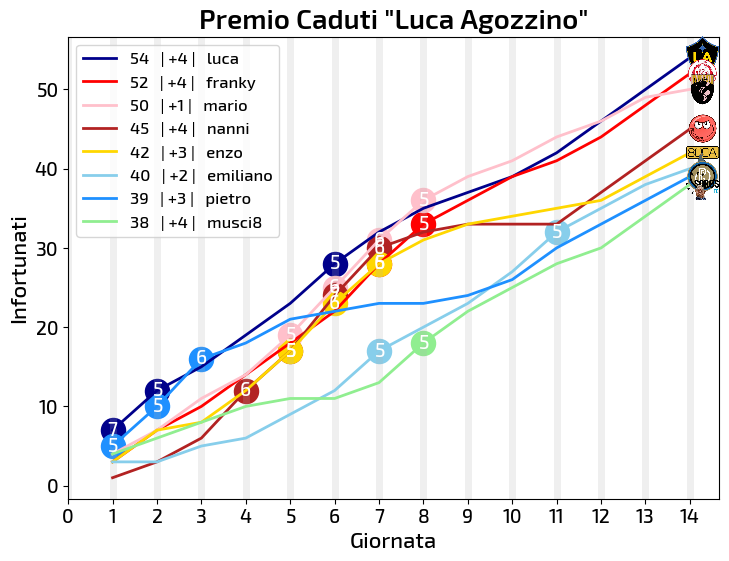

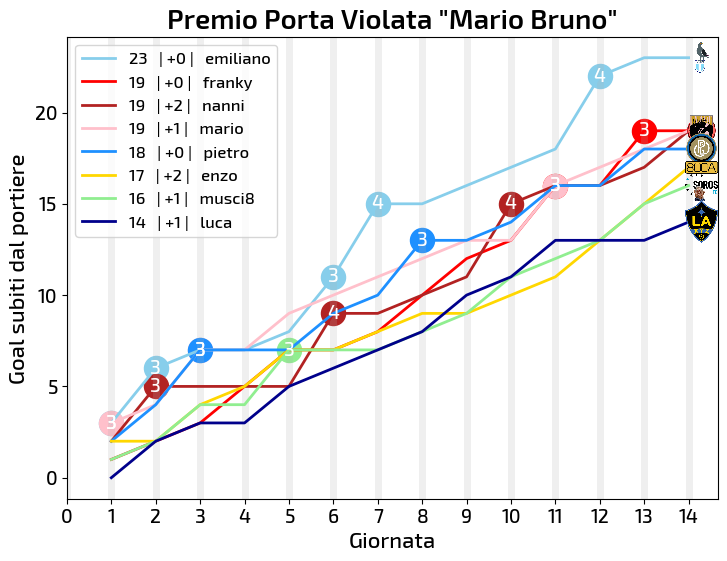

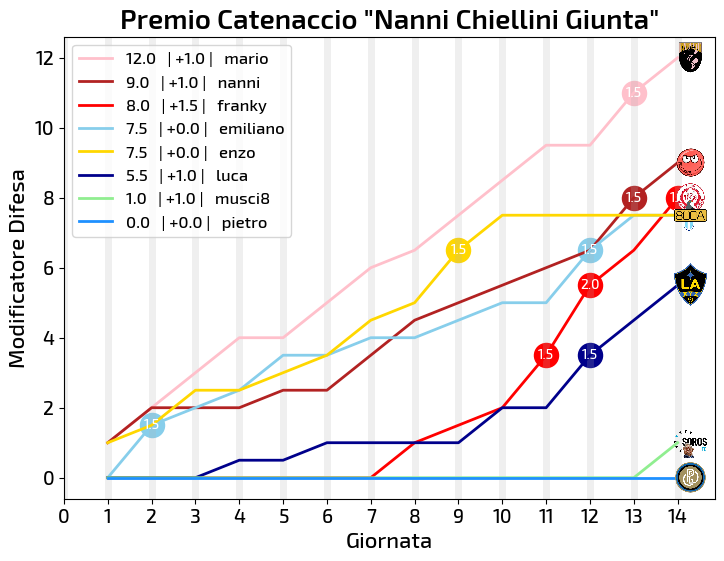

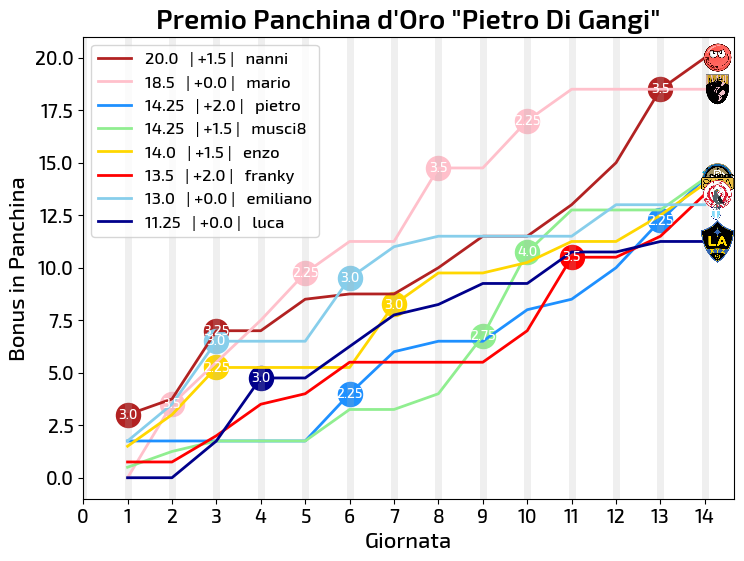

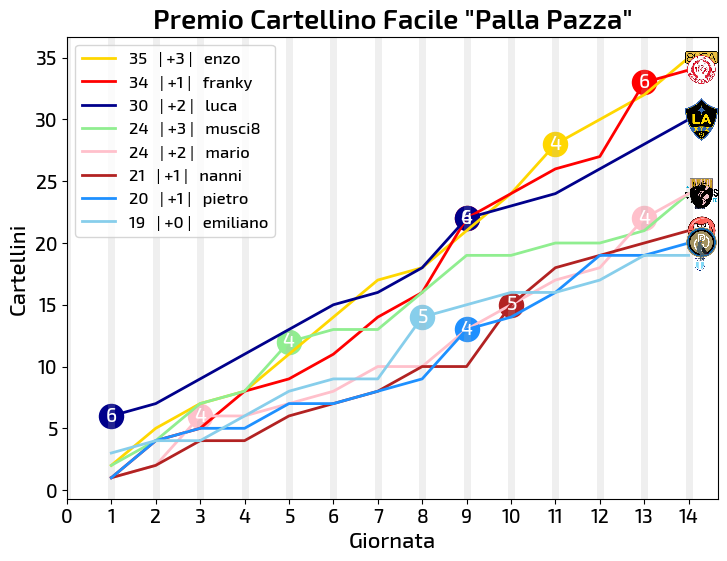

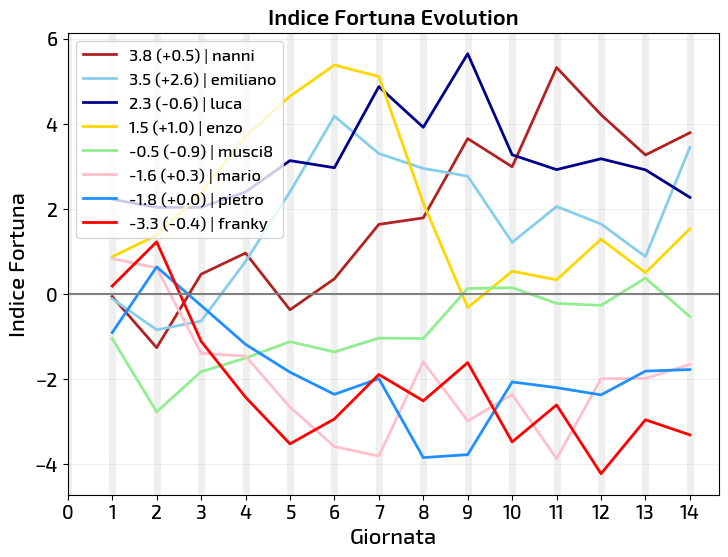

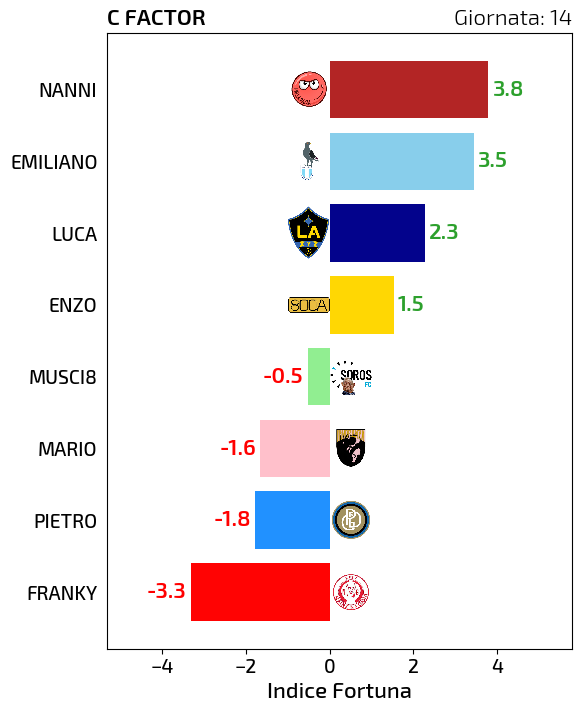

In [5]:
generate_plots()

In [6]:
import json
from pymongo import MongoClient
from pprint import pprint
import pymongo

from datetime import datetime


with open('credential.json','r') as f:
    cred = json.load(f)
    
    
cluster = MongoClient(cred['cred'])
# choosing database
db = cluster["Game"]
# choosing collection
collection = db["Players"]
collection_man = db['Managers']
collection_tr = db['Transfers']

In [7]:
@anvil.server.callable

def test_funct(owner, squad):
    owner = owner.lower()
    squad = squad.lower()
    players = []
    roles = []
    loan = []
    value_init = 0
    value_now = 0
    posts = collection.find({'info.current_team.owner': owner,'info.current_team.squad': squad})
    for player in posts:
        value_init += player['info']['current_team']['quotation_initial']
        value_now += player['info']['stats']['Qt_A']
        players.append(player['name'])
        roles.append(player['info']['personal_info']['FC_role'])
        temp = ''
        if player['info']['current_team']['on_loan']:
            temp = 'on loan'
        loan.append(temp)
    return players, roles, loan, value_init, value_now

In [8]:
@anvil.server.callable

def rose_funct(owner, squad):
    owner = owner.lower()
    squad = squad.lower()
    players = []
    
    value_init = 0
    value_now = 0
    posts = collection.find({'info.current_team.owner': owner,'info.current_team.squad': squad})
    
    mean_age = 0
    
    for player in posts:
        temp = ''
        if player['info']['current_team']['on_loan']:
            temp = '*'
        age = int(np.floor((datetime.today()-datetime.strptime(player['info']['personal_info']['birthdate'], "%d/%m/%Y")).days/365.4))
        players.append({'role': player['info']['personal_info']['FC_role']
                        , 'name': player['name']
                        , 'age': age
                        , 'quotation': player['info']['stats']['Qt_A']
                        , 'quotation_initial': player['info']['contract']['quotation_initial']
                        , 'loan': temp})
        value_init += player['info']['current_team']['quotation_initial']
        value_now += player['info']['stats']['Qt_A']
        mean_age += age
    
    
    posts = collection.find({'info.contract.owner': owner,'info.current_team.on_loan': True})
    for player in posts:
        temp = '**'
        age = int(np.floor((datetime.today()-datetime.strptime(player['info']['personal_info']['birthdate'], "%d/%m/%Y")).days/365.4))
        players.append({'role': player['info']['personal_info']['FC_role']
                        , 'name': player['name']
                        , 'age': age
                        , 'quotation': player['info']['stats']['Qt_A']
                        , 'quotation_initial': player['info']['contract']['quotation_initial']
                        , 'loan': temp})
        value_init += player['info']['current_team']['quotation_initial']
        value_now += player['info']['stats']['Qt_A']
        mean_age += age
    
    mean_age = mean_age/len(players)
    return players, value_init, value_now, round(mean_age, 1)

In [9]:
@anvil.server.callable

def man_data(owner):
    owner = owner.lower()
    dic = collection_man.find_one({'owner': owner})
    dic['main_value'] = 0
    dic['prim_value'] = 0
    for pl in collection.find({'info.current_team.owner': owner,'info.current_team.squad': 'main'}):
        dic['main_value'] += pl['info']['stats']['Qt_A']
    for pl in collection.find({'info.current_team.owner': owner,'info.current_team.squad': 'primavera'}):
        dic['prim_value'] += pl['info']['stats']['Qt_A']
    return dic

In [10]:
def count_prizes(palmares):
    sc=ch=cop=sup=ig=0
    for prize in palmares:
        if prize['Type'] == 'Coppa di Lega':
            cop+=1
        elif prize['Type'] == 'Scudetto':
            sc+=1
        elif prize['Type'] == 'Champions':
            ch+=1
        elif prize['Type'] == 'Supercoppa':
            sup+=1
        elif prize['Type'] in ['Porta Violata', 'Cartellino Facile', 'Panchina D\'Oro', 'Caduti']:
            ig+=1
    return {'sc': sc, 'ch': ch, 'cop': cop, 'sup': sup, 'ig': ig}

In [11]:
@anvil.server.callable

def man_data_tot(owner, res = 'high'):
    dic_res = {
        'low' : '-48',
        'mid' : '-96',
        'high' : '-250'}
    
    owner = owner.lower()
    dic = collection_man.find_one({'owner': owner})
    team_name = dic['team_name']
    dic_out = {}
    
    dic_out['budget'] = dic['budget']
    dic_out['tot_wins'] = dic['total_wins']
    dic_out['tot_cost'] = 'n/a'
    
    dic_out['tot_value'] = 0
    for pl in collection.find({'info.contract.owner': owner}):
        dic_out['tot_value'] += pl['info']['stats']['Qt_A']
    
    dic_out['prizes'] = count_prizes(dic['palmares'])
    
    card = anvil.media.from_file('Logos/'+owner+dic_res[res]+'.png','image/png')
    
    return dic_out, team_name, card

In [12]:
@anvil.server.callable
#cost is yet to fix

def all_managers_data(SC = 360, LTL = 460):
    dict_all = {}
    median_dict ={'Val_M':[],
                 'Val_P':[],
                 'Cost':[],
                 'Age':[]}
    for owner in Teams.keys():
        dict_all[owner],  dict_all[owner]['team_name'],dict_all[owner]['team_logo'] = man_data_tot(owner, 'low')
        _, dict_all[owner]['value_init_main'], dict_all[owner]['value_now_main'], dict_all[owner]['mean_age_main'] = rose_funct(owner, 'main')
        _, dict_all[owner]['value_init_prima'], dict_all[owner]['value_now_prima'], dict_all[owner]['mean_age_prima'] = rose_funct(owner, 'primavera')
        dict_all[owner]['owner'] = owner
        dict_all[owner]['extra_budget'] = max(0, 100 + SC - int(dict_all[owner]['value_now_main']))
        dict_all[owner]['luxury_tax'] = max(0, int(dict_all[owner]['value_now_main']) - LTL)
        
        median_dict['Val_M'].append(int(dict_all[owner]['value_now_main']))
        median_dict['Val_P'].append(int(dict_all[owner]['value_now_prima']))
        median_dict['Age'].append(int(dict_all[owner]['mean_age_main']))
    
    median_dict['Val_M'] = str(np.median(median_dict['Val_M']))
    median_dict['Val_P'] = str(np.median(median_dict['Val_P']))
    median_dict['Age'] = str(np.median(median_dict['Age']))
    median_dict['Cost'] = 'N/A'#np.median(median_dict['Age'])
        
    return dict_all, median_dict

In [13]:
@anvil.server.callable

def man_team_name(owner):
    owner = owner.lower()
    dic = collection_man.find_one({'owner': owner})
    
    return dic['team_name']

In [14]:
@anvil.server.callable
def pl_names():
    posts = collection.find({})
    players = []
    for post in posts:
        players.append(post['name'])
    return sorted(players)

In [15]:
@anvil.server.callable
def pl_info(name):
    dic = collection.find_one({'name': name})
    dic_stats = dic['info']['stats']
    
    name_url = dic['name']
    name_url = name_url.replace(' ','-')
    name_url = name_url.replace('.','')
    
    card = URLMedia('https://content.fantacalcio.it/web/campioncini/card/'+name_url+'.jpg')
    stats_link = 'https://www.fantacalcio.it/squadre/'+dic['info']['personal_info']['team_real']+'/'+name_url+'/'+str(dic['_id'])
    
    return dic, dic_stats, card, stats_link

In [16]:
@anvil.server.callable
def stats_link_up(name):
    dic = collection.find_one({'name': name})
    name_url = dic['name']
    name_url = name_url.replace(' ','-')
    name_url = name_url.replace('.','')
    stats_link = 'https://www.fantacalcio.it/squadre/'+dic['info']['personal_info']['team_real']+'/'+name_url+'/'+str(dic['_id'])
    return stats_link

In [17]:
@anvil.server.callable
def find_trans(name = False, operation = False, year = False, owner = False):
    filt = {}
    if name:
        filt['name'] ={'$regex':''+name,'$options':'i'}
    if operation:
        filt['operation'] = operation
    if year:
        filt['date'] ={'$regex':'^'+str(year),'$options':'i'}
    posts = []
    for dic in collection_tr.find(filt):
        owner = 'N/A'
        if 'owner' in dic.keys():
            owner = dic['owner']
        elif 'new_owner' in dic.keys():
            owner = dic['new_owner']
        elif 'exch_owner' in dic.keys():
            owner = dic['exch_owner']
            
        posts.append({'name': dic['name'],'operation':dic['operation'],'date':dic['date'], 'owner': owner})
    
    return posts

In [18]:
@anvil.server.callable
def find_players(name):
    filt = {}
    filt['name'] ={'$regex':''+name,'$options':'i'}
    posts = []
    for dic in collection.find(filt):
            
        posts.append(dic['name'])
    
    return posts

In [19]:
@anvil.server.callable
def load_plot_IG(plot):
    premio_plot(Results, giornate, Teams, Logos, plot)
    card = anvil.media.from_file('Plots/plot_'+ plot +'.png','image/png')
    return card

In [20]:
def load_plot_C(plot):
    #fortuna_evo(Results, Teams, Tot_per_round)
    #C_factor_logos_2(Total, giornate, Teams, tot_giornate, Logos)
    card = anvil.media.from_file('Plots/C_fact_'+ plot +'.png','image/png')
    return card

In [21]:
@anvil.server.callable
def load_plot_C_all():
    card_hist = anvil.media.from_file('Plots/C_fact_'+ 'Historic' +'.png','image/png')
    card_tot = anvil.media.from_file('Plots/C_fact_'+ 'Total' +'.png','image/png')
    return giornate, card_tot, card_hist

In [22]:
@anvil.server.callable
def load_logo(name, res = 'mid'):
    dic_res = {
        'low' : '-48',
        'mid' : '-96',
        'high' : '-250',
    }
    path = 'Logos/'+name + dic_res[res]+'.png'
    card = anvil.media.from_file(path,'image/png')
    return card

In [23]:
#fortuna_evo(Results, Teams, Tot_per_round)
#C_factor_logos_2(Total, giornate, Teams, tot_giornate, Logos)
#for premio in ['Caduti','Porta Violata','Catenaccio','Panchina Oro','Cartellino Facile']:
 #   premio_plot(Results, giornate, Teams, Logos, premio)

In [24]:
@anvil.server.callable
def load_IGNOBEL_db(plot):
    #tot = premio_plot(Results, giornate, Teams, Logos, plot)
    list_IG = sorted(dict_out[plot], key = lambda i: i['points'], reverse = True)
    i=1
    prize = 7 #to be determined via mongodb
    for el in list_IG:
        el['position'] = i
        el['team'] = el['team'].capitalize()
        el['prize'] = prize
        i+=1
    card = anvil.media.from_file('Plots/plot_'+ plot +'.png','image/png')
    #out_plot = load_plot_IG(plot)
    montepremi = str(4*prize) 
    return card, list_IG, giornate, montepremi

In [25]:
@anvil.server.callable
def load_IGNOBEL_db_all():
    montepremi = 0
    list_IG = {}
    card = {}
    for plot in ['Porta Violata', 'Cartellino Facile', 'Panchina Oro', 'Caduti']:
        list_IG[plot] = sorted(dict_out[plot], key = lambda i: i['points'], reverse = True)
        i=1
        prize = 7 #to be determined via mongodb
        for el in list_IG[plot]:
            el['position'] = i
            el['team'] = el['team'].capitalize()
            el['prize'] = prize
            i+=1
        card[plot] = anvil.media.from_file('Plots/plot_'+ plot +'.png','image/png')
        montepremi += prize
    return card, list_IG, giornate, montepremi